In [16]:
!pip install numpy

In [17]:
import os
import pandas as pd
import openpyxl
import matplotlib.pyplot as plt
import numpy as np



In [20]:
# 이탈자데이터 디렉토리 경로
directory = r'C:\Users\me\Downloads\신청페이지 들어간사람\l_q'

# 모든 엑셀 파일의 경로를 가져오기
file_paths = [os.path.join(directory, file) for file in os.listdir(directory) if file.endswith('.xlsx')]

# 엑셀 파일을 읽어들여 데이터프레임으로 변환하여 리스트에 저장
dfs = []
for file_path in file_paths:
    # 파일명에서 확장자를 제외한 부분 추출
    file_name = os.path.splitext(os.path.basename(file_path))[0]
    # 엑셀 파일을 읽어들여 데이터프레임으로 변환
    df = pd.read_excel(file_path, dtype=str)
    # 'date' 열에 파일명에서 추출한 값을 추가
    df['date'] = file_name
    dfs.append(df)
    
# 리스트에 있는 모든 데이터프레임을 하나로 합치기
merged_df = pd.concat(dfs, ignore_index=True)


# '체류시간' 열의 데이터 유형이 숫자가 아닌 경우 숫자로 변환
merged_df['체류시간'] = pd.to_numeric(merged_df['체류시간'], errors='coerce')

# 체류시간을 10초 간격으로 나누어 새로운 열 추가
merged_df['10초_구간'] = (merged_df['체류시간'] // 10) * 10


In [21]:
df=merged_df.copy()

In [22]:
scroll_move_ratio = df.groupby('스크롤여부')['체류시간'].mean()
scroll_move_ratio

스크롤여부
N     40.220000
Y    312.361702
Name: 체류시간, dtype: float64

In [23]:
# 체류시간을 기준으로 데이터프레임 정렬
sorted_df = df.sort_values(by='체류시간')

# 데이터프레임의 행 수 계산
total_rows = len(sorted_df)

# 데이터프레임을 10%씩 끊어줌
batch_size = total_rows // 10  # 전체 행 수의 10%
for i in range(0, total_rows, batch_size):
    batch = sorted_df.iloc[i:i+batch_size]
    print(f"10% 그룹: {i // batch_size + 1}")
    print(batch)

10% 그룹: 1
                      아이디 스크롤여부 클릭여부  체류시간      date  10초_구간
4    897612168.1712381373     N    N     0  20240406       0
36  1528401108.1712795066     N    N     0  20240411       0
28   769084440.1712630466     N    N     0  20240409       0
68  1630881759.1712506650     N    N     1  20240415       0
17   832364163.1712350271     N    N     6  20240408       0
61   265703056.1713064488     N    N     6  20240414       0
5   1544713509.1709635574     Y    N     8  20240407       0
86   516240920.1713361355     Y    N     9  20240417       0
89  1678220891.1697039189     N    N    10  20240418      10
10% 그룹: 2
                      아이디 스크롤여부 클릭여부  체류시간      date  10초_구간
33   230071811.1712568211     N    N    11  20240410      10
58   651048818.1712986307     N    N    13  20240413      10
0   1042732193.1712370545     Y    N    14  20240406      10
44  1998822270.1712899188     N    N    14  20240412      10
91  2055683601.1713421519     N    N    16  20240418      10
87  

In [27]:
def detect_outliers(data):
    """
    주어진 데이터에서 이상치를 판단하는 함수
    :param data: 이상치를 판단할 데이터 (시리즈 형태)
    :return: 이상치 여부를 나타내는 시리즈를 반환
    """
    # Z-점수 계산
    z_scores = np.abs((data - np.mean(data)) / np.std(data))
    # 이상치 판단
    outliers_mask = z_scores > 3
    return outliers_mask

# merged_df['체류시간'] 데이터를 사용하여 이상치 여부를 판단
outliers_mask = detect_outliers(df['체류시간'])

# 이상치 여부를 나타내는 열 추가
df['이상치'] = outliers_mask

In [28]:
df

,아이디,스크롤여부,클릭여부,체류시간,date,10초_구간,이상치
0,1042732193.1712370545,Y,N,14,20240406,10,False
1,1079018900.1712339738,N,N,24,20240406,20,False
2,255156580.1710166598,Y,N,58,20240406,50,False
3,614537027.1712375608,Y,N,9896,20240406,9890,True
4,897612168.1712381373,N,N,0,20240406,0,False
...,...,...,...,...,...,...,...
92,275401744.1713443022,Y,N,120,20240418,120,False
93,292222284.1713431524,Y,N,216,20240418,210,False
94,394290700.1713396408,N,N,130,20240418,130,False
95,783200338.1713418757,N,N,28,20240418,20,False


In [30]:
# 누적 비율을 계산하여 %로 나타내는 함수
def calculate_cumulative_percentage(index):
    return int((index + 1) / total_records * 100)

# 체류시간 열을 내림차순으로 정렬
sorted_df = df.sort_values(by='체류시간', ascending=False)

# 새로운 열 '누적 비율(%)'을 추가하여 누적 비율을 계산
total_records = len(sorted_df)
sorted_df['누적 비율(%)'] = (sorted_df.reset_index().index).map(calculate_cumulative_percentage)

# 결과 확인
print(sorted_df)

                      아이디 스크롤여부 클릭여부  체류시간      date  10초_구간    이상치  누적 비율(%)
3    614537027.1712375608     Y    N  9896  20240406    9890   True         1
51  1081504003.1709814290     Y    N   519  20240413     510  False         2
22  1547882279.1712643230     Y    N   273  20240409     270  False         3
56  1757320362.1712374849     Y    N   259  20240413     250  False         4
66  1190897750.1713108544     Y    Y   235  20240415     230  False         5
..                    ...   ...  ...   ...       ...     ...    ...       ...
61   265703056.1713064488     N    N     6  20240414       0  False        95
68  1630881759.1712506650     N    N     1  20240415       0  False        96
28   769084440.1712630466     N    N     0  20240409       0  False        97
36  1528401108.1712795066     N    N     0  20240411       0  False        98
4    897612168.1712381373     N    N     0  20240406       0  False       100

[97 rows x 8 columns]


In [9]:
merged_df.to_excel("test.xlsx")

In [75]:
statistics = merged_df.groupby(['10초_구간', '이탈유형']).size().unstack(fill_value=0)
# 각 구간별 'out'과 'in'의 합계를 계산하여 새로운 열 추가
statistics['total'] = statistics.sum(axis=1)

In [77]:
df_reset = statistics.rename_axis(None, axis=1)
df_reset.index.name = None
df_reset.to_excel("test.xlsx")

In [63]:
df_subset = statistics[['10초_구간', 'in', 'out', 'total']].copy()
df_subset

이탈유형,10초_구간,in,out,total
0,0,16,1175,1191
1,10,17,36,53
2,20,13,34,47
3,30,9,30,39
4,40,6,29,35
5,50,0,23,23
6,60,3,21,24
7,70,2,11,13
8,80,4,12,16
9,90,1,8,9


In [61]:
df_subset = statistics[['10초_구간', 'in', 'out', 'total']].copy()
df_subset.set_index('10초_구간', inplace=False)


이탈유형,in,out,total
10초_구간,,,
0,16,1175,1191
10,17,36,53
20,13,34,47
30,9,30,39
40,6,29,35
50,0,23,23
60,3,21,24
70,2,11,13
80,4,12,16


In [62]:
df_subset

이탈유형,10초_구간,in,out,total
0,0,16,1175,1191
1,10,17,36,53
2,20,13,34,47
3,30,9,30,39
4,40,6,29,35
5,50,0,23,23
6,60,3,21,24
7,70,2,11,13
8,80,4,12,16
9,90,1,8,9


Text(0.5, 0, '10-second intervals')

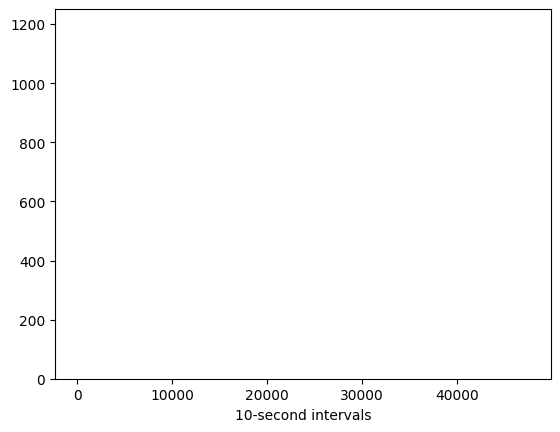

In [38]:
plt.bar(statistics.index, statistics['in'], color='blue', label='in')
plt.bar(statistics.index, statistics['out'], bottom=statistics['in'], color='orange', label='out')
plt.xlabel('10-second intervals')


In [ ]:
# 합쳐진 데이터프레임을 엑셀 파일로 저장
merged_df.to_excel('merged_data.xlsx', index=False)

print("모든 엑셀 파일을 합쳐서 merged_data.xlsx로 저장되었습니다.")
